In [7]:
from dataclasses import asdict

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig
from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.models.neurad import NeuRADModel, NeuRADModelConfig
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig

sequence = "001"

pipeline_config = DiffusionNerfConfig(
    max_steps=40001,
    calc_fid_steps=tuple(range(0, 40001, 5000)),
    ray_patch_size=(128, 128),
    nerf_checkpoint=f"models/diffusionnerf/base-neurad/{sequence}/nerfstudio_models/step-000040000.ckpt",
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",), sequence=sequence),
        train_num_rays_per_batch=16384,
        eval_num_rays_per_batch=16384,
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
    )
pipe = pipeline_config.setup(device="cuda")

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


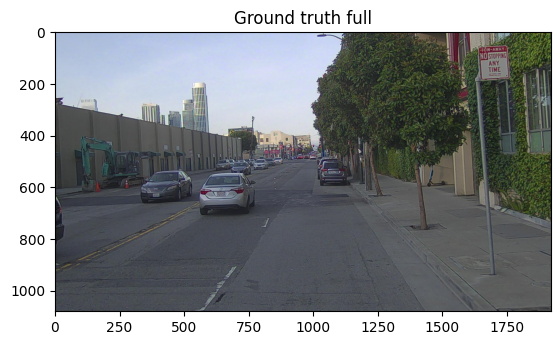

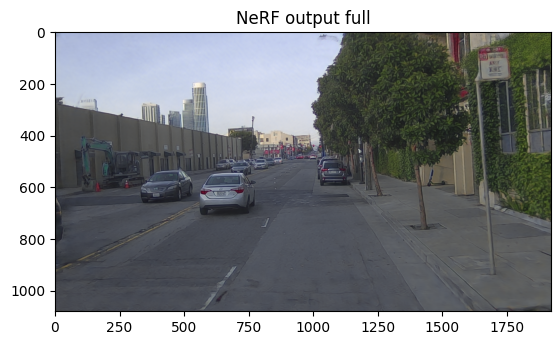

In [8]:
import torch
from nerfstudio.generative.utils import show_img

pipe.eval()



from pathlib import Path
import pickle

SAVE_MOCK = False

mock_path = Path("tests/mock_data")
full_image_path = mock_path / "full_image"


if SAVE_MOCK:
    with torch.no_grad():
        full_image_path.mkdir(exist_ok=True, parents=True)

        camera, batch = pipe.datamanager.next_eval_image(0)
        with torch.no_grad():
            outputs = pipe.model.get_outputs_for_camera(camera)

        with open(full_image_path / "camera.pkl", "wb") as f:
            pickle.dump(camera, f)
        with open(full_image_path / "batch.pkl", "wb") as f:
            pickle.dump(batch, f)
        with open(full_image_path / "outputs.pkl", "wb") as f:
            pickle.dump(outputs, f)

        

with open(full_image_path / "camera.pkl", "rb") as f:
    camera_full = pickle.load(f)
with open(full_image_path / "batch.pkl", "rb") as f:
    batch_full = pickle.load(f)
with open(full_image_path / "outputs.pkl", "rb") as f:
    outputs_full = pickle.load(f)
import matplotlib.pyplot as plt

gt_full = batch_full["image"]
nerf_out_full = outputs_full["rgb"]
plt.imshow(gt_full.cpu().numpy())
plt.title("Ground truth full")
plt.show()

plt.imshow(nerf_out_full.cpu().numpy())
plt.title("NeRF output full")
plt.show()



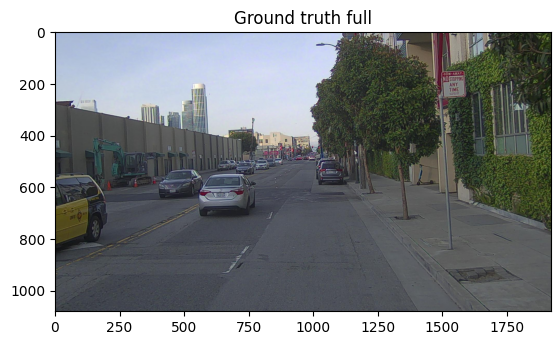

In [9]:
from nerfstudio.cameras.cameras import Cameras


with torch.no_grad():
    p = Path("tests/mock_data/shift_v_unshifted/full_image")
    with open(p / "camera.pkl", "rb") as f:
        camera = pickle.load(f)
    with open(p / "batch.pkl", "rb") as f:
        batch = pickle.load(f)
    
    with torch.no_grad():
        outputs = pipe.model.get_outputs_for_camera(camera)

gt_full = batch["image"]

plt.imshow(gt_full.cpu().numpy())
plt.title("Ground truth full")
plt.show()

def get_cam(pos_x, rot_z) -> Cameras:
    with open(full_image_path / f"camera_{-pos_x}_{rot_z}.pkl", "rb") as f:
        return pickle.load(f)

In [10]:
from copy import deepcopy
from typing import Tuple
from torch import Tensor
from PIL import Image
import torch
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.pipelines.diffusion_nerf_pipeline import PoseConfig, rotate_around


def shift_cameras(cameras: Cameras, pose_offset: Tensor) -> Tuple[Cameras, Tensor]:
    cameras = deepcopy(cameras)
    device = cameras.device
    aug_translation = pose_offset[..., :3].to(device=device)  # 3
    aug_rotation = pose_offset[..., 3:].to(device=device)  # 3

    c2w = cameras.camera_to_worlds 
    translation = c2w[..., :3] @ aug_translation

    local_rotation = (  # Chain together rotations, X -> Y -> Z
        rotate_around(aug_rotation[2], 2)
        @ rotate_around(aug_rotation[1], 1)
        @ rotate_around(aug_rotation[0], 0)
    ).to(device)
    c2w[:, :3, :3] = local_rotation @ c2w[:, :3, :3]
    c2w[:, :3, 3:4] += translation.reshape(-1, 3, 1)

    cameras.camera_to_worlds = c2w

    with torch.no_grad():
        img_out = pipe.model.get_outputs_for_camera(cameras)

    return cameras, img_out


def prettify_img(img: Tensor, title: str = ""):
    img = img.detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    pil_image = Image.fromarray((img * 255).astype("uint8")) 
    return pil_image


In [11]:
import itertools as it

GEN_BASE_DEGREDATION = False
if GEN_BASE_DEGREDATION:
    imgs_dir = Path("experiments/Images")
    experiment_name = "Neurad_Baseline"
    task_name = "unseen_test"
    img_subdir = imgs_dir / task_name / sequence
    img_subdir.mkdir(parents=True, exist_ok=True)

    shift_xs = [0, -4, -8]
    rot_zs = [0, 30, 45]

    for shift_x, rot_z in it.product(shift_xs, rot_zs):
        camera_shifted, img_out = shift_cameras(camera, pose_offset=PoseConfig(pos_x=shift_x, rot_z=rot_z).tensor_rad)
        img = prettify_img(img_out["rgb"])
        img_name = f"base_neurad_{shift_x}_{rot_z}.png"
        img_path = img_subdir / img_name

        img.save(img_path)

In [ ]:
import itertools as it

GEN_DIFFUSION = False
if GEN_DIFFUSION:
    imgs_dir = Path("experiments/Images")
    experiment_name = "Neurad_Base_Diffusion_Sweep"
    task_name = "diffusion_improvement"
    img_subdir = imgs_dir / task_name / sequence
    img_subdir.mkdir(parents=True, exist_ok=True)

    shift_xs = [0, -4, -8]
    rot_zs = [0, 30, 45]
    noise_strengths = [0.1, 0.3, 0.5]

    for noise_strength in noise_strengths:
        diffusion_model = DiffusionModelConfig(
            dtype="fp16",
            noise_strength=noise_strength,
        ).setup(device="cuda")
        for shift_x, rot_z in it.product(shift_xs, rot_zs):
            camera_shifted, img_out = shift_cameras(camera, pose_offset=PoseConfig(pos_x=shift_x, rot_z=rot_z).tensor_rad)
            img = prettify_img(img_out["rgb"])
            img_name = f"neurad_base_diffusion_sweep_{shift_x}_{rot_z}_neurad.png"
            img_path = img_subdir / img_name

            with torch.no_grad():
                diffusion_output = diffusion_model.get_diffusion_output(img_out)
            diff_img = prettify_img(diffusion_output["rgb"].squeeze())
            diff_img_name = f"neurad_base_diffusion_sweep_{shift_x}_{rot_z}_{str(noise_strength).replace('.', '')}.png"
            diff_img_path = img_subdir / diff_img_name

            img.save(img_path)
            diff_img.save(diff_img_path)

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
